# Faster R-CNN with FPN training on MOT17



In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive



## Download torchvision and coco

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 4.20 MiB/s, done.
Resolving deltas: 100% (576/576), done.
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-m

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 66127, done.
remote: Counting objects: 100% (1191/1191), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 66127 (delta 1057), reused 1167 (delta 1048), pack-reused 64936
Receiving objects: 100% (66127/66127), 125.16 MiB | 23.75 MiB/s, done.
Resolving deltas: 100% (54174/54174), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d version check against PyTorch's CUDA version


In [ ]:
pwd

'/content'

# OBTAIN MY OWN DATASET

In [ ]:
#rm -r /content/train/

In [ ]:
#%cp -avr /content/gdrive/MyDrive/DATA/MOT17Det.zip /content/


In [ ]:
%cp -avr /content/gdrive/MyDrive/DATA/Datos_train_test_bueno.zip /content/


'/content/gdrive/MyDrive/DATA/Datos_train_test_bueno.zip' -> '/content/Datos_train_test_bueno.zip'


In [ ]:
!unzip /content/Datos_train_test_bueno.zip

Archive:  /content/Datos_train_test_bueno.zip
   creating: mi_MOT17Det-train500-1500-test548/
   creating: mi_MOT17Det-train500-1500-test548/test/
   creating: mi_MOT17Det-train500-1500-test548/test/MOT17-01/
   creating: mi_MOT17Det-train500-1500-test548/test/MOT17-01/gt/
  inflating: mi_MOT17Det-train500-1500-test548/test/MOT17-01/gt/gt.txt  
   creating: mi_MOT17Det-train500-1500-test548/test/MOT17-01/img1/
  inflating: mi_MOT17Det-train500-1500-test548/test/MOT17-01/img1/000001.jpg  
  inflating: mi_MOT17Det-train500-1500-test548/test/MOT17-01/img1/000002.jpg  
  inflating: mi_MOT17Det-train500-1500-test548/test/MOT17-01/img1/000003.jpg  
  inflating: mi_MOT17Det-train500-1500-test548/test/MOT17-01/img1/000004.jpg  
  inflating: mi_MOT17Det-train500-1500-test548/test/MOT17-01/img1/000005.jpg  
  inflating: mi_MOT17Det-train500-1500-test548/test/MOT17-01/img1/000006.jpg  
  inflating: mi_MOT17Det-train500-1500-test548/test/MOT17-01/img1/000007.jpg  
  inflating: mi_MOT17Det-train500

In [ ]:
%mv  -v /content/mi_MOT17Det-train500-1500-test548/* /content

renamed '/content/mi_MOT17Det-train500-1500-test548/test' -> '/content/test'
renamed '/content/mi_MOT17Det-train500-1500-test548/train' -> '/content/train'


In [ ]:
rm /content/mi_MOT17Det/

rm: cannot remove '/content/mi_MOT17Det/': No such file or directory


In [ ]:
pwd

'/content'


Here is one example of an image in the dataset, with its corresponding instance segmentation mask

In [ ]:
ls train/MOT17-02/img1/000001.jpg


train/MOT17-02/img1/000001.jpg


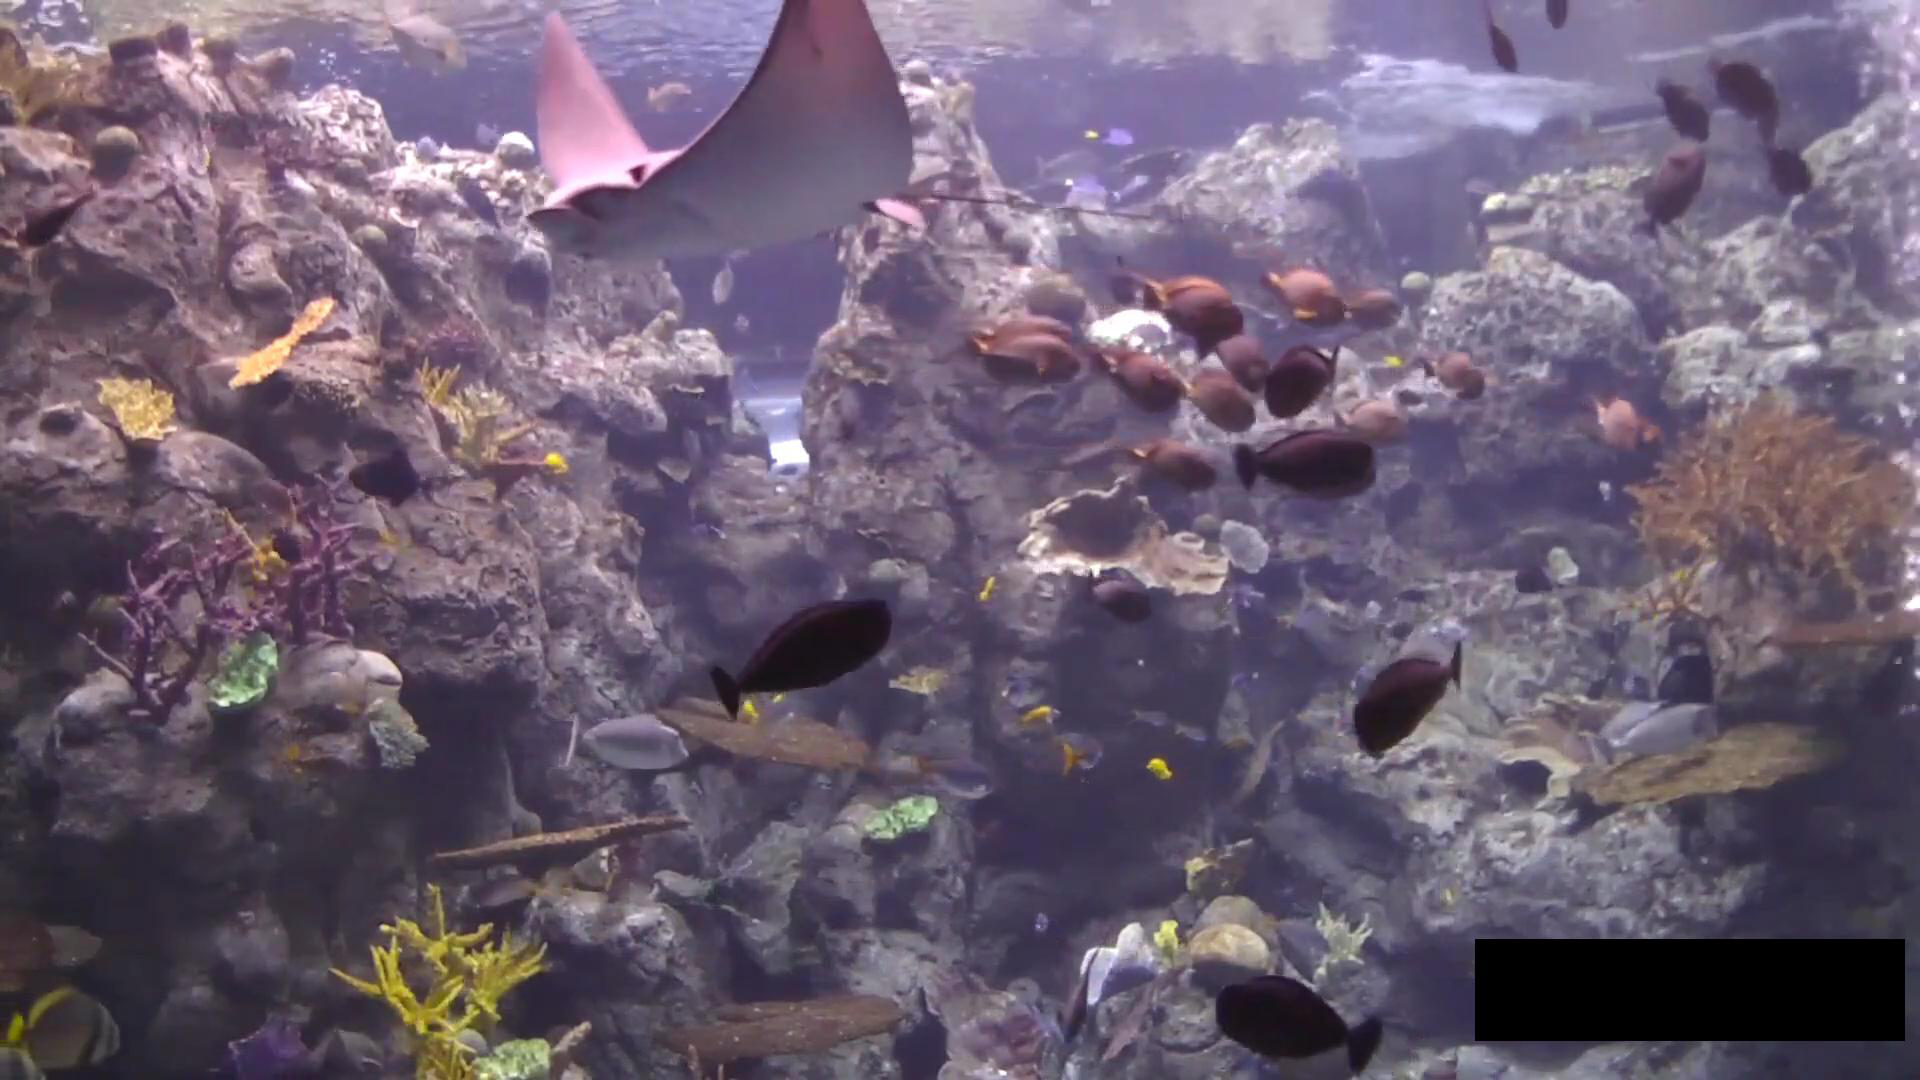

In [ ]:
from PIL import Image
Image.open('train/MOT17-02/img1/000001.jpg')

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

Explicacion del codigo de abajo: https://www.youtube.com/watch?v=PXOzkkB5eH0

In [ ]:
import configparser
import csv
import os
import os.path as osp
import pickle

from PIL import Image
import numpy as np
import scipy
import torch


class MOT17ObjDetect(torch.utils.data.Dataset):
    """ Data class for the Multiple Object Tracking Dataset
    """

    def __init__(self, root, transforms=None, vis_threshold=0.5): #LO HE CAMBIADO DE 0.25 A 0.5
        self.root = root
        self.transforms = transforms
        self._vis_threshold = vis_threshold
        self._classes = ('background', 'fish')
        self._img_paths = []
        print(os.listdir(root))
        for f in (os.listdir(root)):
            path = os.path.join(root, f)
            config_file = os.path.join(path, 'seqinfo.ini')
            print(config_file)
            assert os.path.exists(config_file), \
                'Path does not exist: {}'.format(config_file)

            config = configparser.ConfigParser()
            config.read(config_file)
            seq_len = int(config['Sequence']['seqLength'])
            #seq_len=seq_len-1
            print(seq_len)
            im_width = int(config['Sequence']['imWidth'])
            im_height = int(config['Sequence']['imHeight'])
            im_ext = config['Sequence']['imExt']
            im_dir = config['Sequence']['imDir']

          #  print(im_dir)
           # print(im_ext)

            _imDir = os.path.join(path, im_dir)

            for i in range(1, seq_len + 1):
                img_path = os.path.join(_imDir, f"{i:06d}{im_ext}")
               # print(img_path)
               # assert os.path.exists(img_path), \
                  #  'Path does not exist: {img_path}'
                # self._img_paths.append((img_path, im_width, im_height))
                self._img_paths.append(img_path)

    @property
    def num_classes(self):
        return len(self._classes)

    def _get_annotation(self, idx):
        """
        """

        if 'test' in self.root:
          
            num_objs = 0
            boxes = torch.zeros((num_objs, 4), dtype=torch.float32)

            return {'boxes': boxes,
                'labels': torch.ones((num_objs,), dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                'iscrowd': torch.zeros((num_objs,), dtype=torch.int64),
                'visibilities': torch.zeros((num_objs), dtype=torch.float32)}
                
        img_path = self._img_paths[idx]
        file_index = int(os.path.basename(img_path).split('.')[0])

        gt_file = os.path.join(os.path.dirname(
            os.path.dirname(img_path)), 'gt', 'gt.txt')

        assert os.path.exists(gt_file), \
            'GT file does not exist: {}'.format(gt_file)

        bounding_boxes = []

        with open(gt_file, "r") as inf:
            reader = csv.reader(inf, delimiter=',')
            for row in reader:
                visibility = float(row[8])
                if int(row[0]) == file_index and int(row[6]) == 1 and int(row[7]) == 1 and visibility >= self._vis_threshold:
                    bb = {}
                    bb['bb_left'] = int(float(row[2]))
                    bb['bb_top'] = int(float(row[3]))
                    bb['bb_width'] = int(float(row[4]))
                    bb['bb_height'] = int(float(row[5]))
                    bb['visibility'] = float(row[8])

                    bounding_boxes.append(bb)

        num_objs = len(bounding_boxes)

        boxes = torch.zeros((num_objs, 4), dtype=torch.float32)
        visibilities = torch.zeros((num_objs), dtype=torch.float32)
        
        for i, bb in enumerate(bounding_boxes):
            # Make pixel indexes 0-based, should already be 0-based (or not)
            x1 = bb['bb_left'] - 1
            y1 = bb['bb_top'] - 1
            # This -1 accounts for the width (width of 1 x1=x2)
            x2 = x1 + bb['bb_width'] - 1
            y2 = y1 + bb['bb_height'] - 1

            boxes[i, 0] = x1
            boxes[i, 1] = y1
            boxes[i, 2] = x2
            boxes[i, 3] = y2
            visibilities[i] = bb['visibility']
            
        return {'boxes': boxes,
                'labels': torch.ones((num_objs,), dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                'iscrowd': torch.zeros((num_objs,), dtype=torch.int64),
                'visibilities': visibilities,}

    def __getitem__(self, idx): #returns a tuple
        # load images ad masks
        img_path = self._img_paths[idx]
        # mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        target = self._get_annotation(idx)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self._img_paths)
    
    def write_results_files(self, results, output_dir):
        """Write the detections in the format for MOT17Det sumbission

        all_boxes[image] = N x 5 array of detections in (x1, y1, x2, y2, score)

        Each file contains these lines:
        <frame>, <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <conf>, <x>, <y>, <z>

        Files to sumbit:
        ./MOT17-01.txt
        ./MOT17-02.txt
        ./MOT17-03.txt
        ./MOT17-04.txt
        ./MOT17-05.txt
        ./MOT17-06.txt
        ./MOT17-07.txt
        ./MOT17-08.txt
        ./MOT17-09.txt
        ./MOT17-10.txt
        ./MOT17-11.txt
        ./MOT17-12.txt
        ./MOT17-13.txt
        ./MOT17-14.txt
        """

        #format_str = "{}, -1, {}, {}, {}, {}, {}, -1, -1, -1"

        files = {}
        for image_id, res in results.items():
            path = self._img_paths[image_id]
            img1, name = osp.split(path)
            # get image number out of name
            frame = int(name.split('.')[0])
            # smth like /train/MOT17-09-FRCNN or /train/MOT17-09
            tmp = osp.dirname(img1)
            # get the folder name of the sequence and split it
            tmp = osp.basename(tmp).split('-')
            # Now get the output name of the file
            out = tmp[0]+'-'+tmp[1]+'.txt'
            outfile = osp.join(output_dir, out)
            #print(outfile)
            # check if out in keys and create empty list if not
            if outfile not in files.keys():
                files[outfile] = []

            for box, score in zip(res['boxes'], res['scores']):
                x1 = box[0].item()
                y1 = box[1].item()
                x2 = box[2].item()
                y2 = box[3].item()
                files[outfile].append(
                    [frame, -1, x1, y1, x2 - x1, y2 - y1, score.item(), -1, -1, -1])

       # print('Creo que antes de entrar en este for da el error bla bla')
        #print(files.items())
        for k, v in files.items():
            with open(k, "w") as of:
                writer = csv.writer(of, delimiter=',')
                for d in v:
                   writer.writerow(d)

    def print_eval(self, results, ovthresh=0.5): #EL THRESHOLD A MODIFICAR
        """Evaluates the detections (not official!!)

        all_boxes[cls][image] = N x 5 array of detections in (x1, y1, x2, y2, score)
        """
        

        if 'test' in self.root:
            print('No GT data available for evaluation.')
            return
            
        # Lists for tp and fp in the format tp[cls][image]
        tp = [[] for _ in range(len(self._img_paths))]
        fp = [[] for _ in range(len(self._img_paths))]
        total_ap = 0
        npos = 0
        gt = []
        gt_found = []
        
        for idx in range(len(self._img_paths)):
            annotation = self._get_annotation(idx)
            bbox = annotation['boxes'][annotation['visibilities'].gt(self._vis_threshold)]
            found = np.zeros(bbox.shape[0])
            gt.append(bbox.cpu().numpy())
            gt_found.append(found)

            npos += found.shape[0]

        # Loop through all images
        # for res in results:
        for im_index, (im_gt, found) in enumerate(zip(gt, gt_found)):
            # Loop through dets an mark TPs and FPs
            
            # im_index = res['image_id'].item()
            # im_det = results['boxes']
            # annotation = self._get_annotation(im_index)
            # im_gt = annotation['boxes'][annotation['visibilities'].gt(0.5)].cpu().numpy()
            # found = np.zeros(im_gt.shape[0])
            
            im_det = results[im_index]['boxes'].cpu().numpy()

            im_tp = np.zeros(len(im_det))
            im_fp = np.zeros(len(im_det))
            for i, d in enumerate(im_det):
                ovmax = -np.inf

                if im_gt.size > 0:
                    # compute overlaps
                    # intersection
                    ixmin = np.maximum(im_gt[:, 0], d[0])
                    iymin = np.maximum(im_gt[:, 1], d[1])
                    ixmax = np.minimum(im_gt[:, 2], d[2])
                    iymax = np.minimum(im_gt[:, 3], d[3])
                    iw = np.maximum(ixmax - ixmin + 1., 0.)
                    ih = np.maximum(iymax - iymin + 1., 0.)
                    inters = iw * ih

                    # union
                    uni = ((d[2] - d[0] + 1.) * (d[3] - d[1] + 1.) +
                            (im_gt[:, 2] - im_gt[:, 0] + 1.) *
                            (im_gt[:, 3] - im_gt[:, 1] + 1.) - inters)

                    overlaps = inters / uni
                    ovmax = np.max(overlaps)
                    jmax = np.argmax(overlaps)

                if ovmax > ovthresh:
                    if found[jmax] == 0:
                        im_tp[i] = 1.
                        found[jmax] = 1.
                    else:
                        im_fp[i] = 1.
                else:
                    im_fp[i] = 1.

            tp[im_index] = im_tp
            fp[im_index] = im_fp

        # Flatten out tp and fp into a numpy array
        i = 0
        for im in tp:
            if type(im) != type([]):
                i += im.shape[0]

        tp_flat = np.zeros(i)
        fp_flat = np.zeros(i)

        i = 0
        for tp_im, fp_im in zip(tp, fp):
            if type(tp_im) != type([]):
                s = tp_im.shape[0]
                tp_flat[i:s+i] = tp_im
                fp_flat[i:s+i] = fp_im
                i += s

        tp = np.cumsum(tp_flat)
        fp = np.cumsum(fp_flat)
        rec = tp / float(npos)
        # avoid divide by zero in case the first detection matches a difficult
        # ground truth (probably not needed in my inference
        # and sum (\Delta recall) * prec
        prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
        tmp = np.maximum(tp + fp, np.finfo(np.float64).eps)

        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]


        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

        tp, fp, prec, rec, ap = np.max(tp), np.max(fp), prec[-1], np.max(rec), ap
        
        print(f"AP: {ap} Prec: {prec} Rec: {rec} TP: {tp} FP: {fp}")
        
        total_ap = total_ap + ap
        return total_ap   
     
    
        

['MOT17-02']
train/MOT17-02/seqinfo.ini
1000
<class 'dict'>
<class 'torch.Tensor'>2


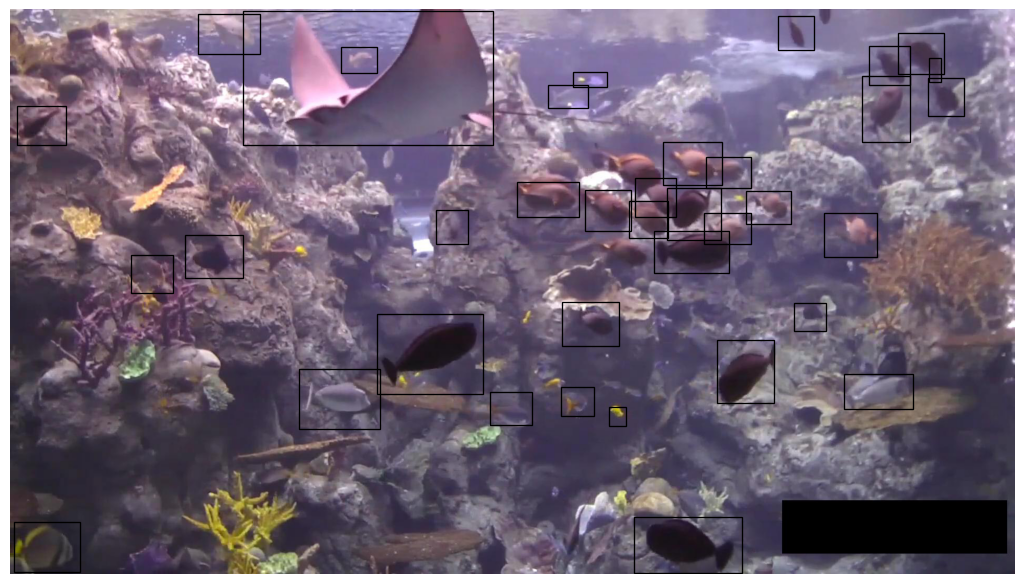

In [ ]:
import matplotlib.pyplot as plt
import transforms as T

dataset = MOT17ObjDetect('train')

img, target = dataset[0]
print(type(target))
def plot(img, boxes):
  print(str(type(boxes))+'2')
  fig, ax = plt.subplots(1, dpi=96)

  img = img.mul(255).permute(1, 2, 0).byte().numpy()
  width, height, _ = img.shape
    
  ax.imshow(img, cmap='gray')
  fig.set_size_inches(width / 80, height / 80)

  for box in boxes:
      rect = plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False,
        linewidth=1.0)
      ax.add_patch(rect)

  plt.axis('off')
  plt.show()



img, target = T.ToTensor()(img, target)

plot(img, target['boxes'])


That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

      
def get_detection_model(num_classes):
    print("Num clases: {}".format(num_classes))
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

   
    

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.nms_thresh = 0.3
    #print(model)

  ## model = TheModelClass(*args, **kwargs)
    
    model.load_state_dict(torch.load("/content/gdrive/MyDrive/Colab Notebooks/model_epoch_50.model")) #FOR LOADING PREVIOUS MODEL
    
    return model

DATASETS

In [ ]:
import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils
import tensorflow as tf

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    losses_graph = []
    losses=[]
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        #print(losses.type)
        loss_value = losses_reduced.item()
        #print(type(loss_value))
        losses_graph.append(loss_value)
        #losses=losses+loss_value
        #tf.concat([losses,loss_value],1)
        losses
        #print("Loss is {}".format(loss_value))
        
        if not math.isfinite(loss_value):
          print("Loss is {}".format(loss_value))
        if not math.isfinite(loss_value): #if the loss_value is not finite, it stops training. 
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return losses_graph, metric_logger

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [ ]:
#from engine import train_one_epoch, evaluate
from engine import evaluate
import utils


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = MOT17ObjDetect('train', get_transform(train=True))
dataset_no_random = MOT17ObjDetect('train', get_transform(train=False))
dataset_test = MOT17ObjDetect('test', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader( #BATCH SIZE ANTES ESTABA A 2
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)
data_loader_no_random = torch.utils.data.DataLoader(
    dataset_no_random, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

['MOT17-02']
train/MOT17-02/seqinfo.ini
1000
['MOT17-02']
train/MOT17-02/seqinfo.ini
1000
['MOT17-01']
test/MOT17-01/seqinfo.ini
548


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


INIT MODEL AND OPTIM

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu') #esto lo he añadido yo

# get the model using our helper function
model = get_detection_model(dataset.num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.1)

Num clases: 2


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

TRAINING

# torchvision.transforms.Resize

PARA EVITAR QUE SE DESCONECTE MIENTRAS ENTRENA.

Pulsar: tecla de acceso directo F12 o Ctrl + Shift + I
En MAC es: opcion (alt) + comando + I

Y pegar este codigo en la consola:

function KeepClicking(){
  console.log("Clicking");
  document.querySelector("colab-toolbar-button#connect").click()
}setInterval(KeepClicking,60000)

https://programmerclick.com/article/96311596441/

In [ ]:
def evaluate_and_write_result_files(model, data_loader):
  model.eval()
  results = {}
  i = 0
  total_score = 0
  print('Evaluating...')
  for imgs, targets in data_loader:
    #print('Evaluating image {}'.format(i))
    imgs = [img.to(device) for img in imgs]
    #print("Num images: {}".format(len(imgs)))

    with torch.no_grad():
        preds = model(imgs)
        #print(preds)
    
    for pred, target in zip(preds, targets):
        results[target['image_id'].item()] = {'boxes': pred['boxes'].cpu(),
                                              'scores': pred['scores'].cpu()}
        #print(total_score)
        #print(pred['scores'].cpu())
        current_score = torch.sum(pred['scores'].cpu())
        total_score = total_score + current_score
        #print('Size total_score: '+str(total_score.size)+' size of pred[scores]: '+str(pred['scores'].size))
    i = i + 1
  
  total_ap=data_loader.dataset.print_eval(results)
  data_loader.dataset.write_results_files(results, 'gdrive/MyDrive/Colab Notebooks/ejecucion/resnet50/')
  return total_ap 
  
## evaluate_and_write_result_files(model, data_loader_test)
total = evaluate_and_write_result_files(model, data_loader_no_random)
print(str(total))

Evaluating...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


AP: 0.5911983387360727 Prec: 0.4893707664124739 Rec: 0.9735570811085685 TP: 22974.0 FP: 23972.0
0.5911983387360727


In [ ]:
num_epochs = 5
losses_epochs = []
total_score_previous=0
for epoch in range(1, num_epochs + 1):
    losses,metriclogger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=200)
    losses_epochs.append(losses[-1])
    
    plt.plot(losses_epochs)
    plt.show()
    # update the learning rate
    # lr_scheduler.step()
    # evaluate on the test dataset
    
   # if epoch % 3 == 0:
    #  evaluate_and_write_result_files(model, data_loader_no_random)
     # torch.save(model.state_dict(), f"/content/gdrive/MyDrive/Colab Notebooks/ejecucion/model_epoch_{epoch}.model")
      
    total_score_value=evaluate_and_write_result_files(model, data_loader_no_random)
    #total_score_value=torch.sum(total_score_actual)
    #print('Model saved')
    #torch.save(model.state_dict(), f"/content/gdrive/MyDrive/Colab Notebooks/ejecucion/model_epoch_{epoch}.model")

    if total_score_value>total_score_previous:
      print('Saving model because actual score: '+str(total_score_value)+'is bigger than the previous one: '+str(total_score_previous))
      total_score_previous=total_score_value
      torch.save(model.state_dict(), f"/content/gdrive/MyDrive/Colab Notebooks/ejecucion/model_epoch_{epoch}.model")
    else: 
      print('NOT saving model because actual score: '+str(total_score_value)+'is smaller than the previous one: '+str(total_score_previous))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1]  [  0/500]  eta: 0:32:42  lr: 0.000010  loss: 0.7109 (0.7109)  loss_classifier: 0.2510 (0.2510)  loss_box_reg: 0.3892 (0.3892)  loss_objectness: 0.0228 (0.0228)  loss_rpn_box_reg: 0.0479 (0.0479)  time: 3.9254  data: 1.8425  max mem: 2774
Epoch: [1]  [200/500]  eta: 0:08:40  lr: 0.000010  loss: 0.5513 (0.5564)  loss_classifier: 0.1798 (0.1845)  loss_box_reg: 0.3357 (0.3162)  loss_objectness: 0.0220 (0.0232)  loss_rpn_box_reg: 0.0262 (0.0325)  time: 1.7223  data: 0.0250  max mem: 2774


## SAME FOR VALIDATION

In [ ]:
import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils
import tensorflow as tf

def validation_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    losses_graph = []
    losses=[]
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        #print(losses.type)
        loss_value = losses_reduced.item()
        #print(type(loss_value))
        losses_graph.append(loss_value)
        #losses=losses+loss_value
        #tf.concat([losses,loss_value],1)
        losses

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        #optimizer.zero_grad()
        #losses.backward()
        #optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return losses_graph, metric_logger

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1]  [  0/549]  eta: 0:07:23  lr: 0.000010  loss: 0.4539 (0.4539)  loss_classifier: 0.3989 (0.3989)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0550 (0.0550)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.8071  data: 0.5153  max mem: 2772
Epoch: [1]  [200/549]  eta: 0:00:52  lr: 0.000010  loss: 0.3875 (0.4293)  loss_classifier: 0.3457 (0.3705)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0390 (0.0588)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1431  data: 0.0067  max mem: 2772
Epoch: [1]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4954 (0.4222)  loss_classifier: 0.4087 (0.3612)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0833 (0.0610)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1404  data: 0.0067  max mem: 2772
Epoch: [1]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5439 (0.4554)  loss_classifier: 0.4513 (0.3906)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0831 (0.0648)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1388  data: 0.0066  max mem: 2772


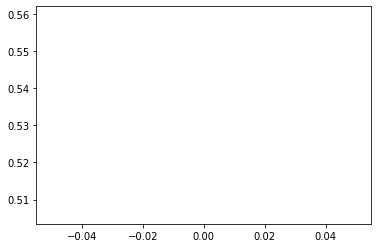

Epoch: [2]  [  0/549]  eta: 0:05:56  lr: 0.000010  loss: 0.3732 (0.3732)  loss_classifier: 0.3347 (0.3347)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0384 (0.0384)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6492  data: 0.4409  max mem: 2772
Epoch: [2]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3860 (0.4302)  loss_classifier: 0.3280 (0.3666)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0562 (0.0637)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1402  data: 0.0065  max mem: 2772
Epoch: [2]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4643 (0.4210)  loss_classifier: 0.4150 (0.3589)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0590 (0.0621)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1410  data: 0.0052  max mem: 2772
Epoch: [2]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5044 (0.4552)  loss_classifier: 0.4331 (0.3887)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0761 (0.0665)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1392  data: 0.0062  max mem: 2772


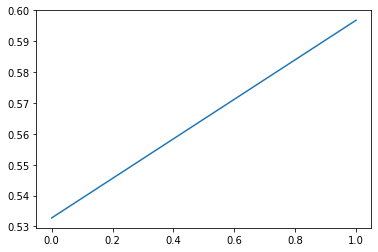

Epoch: [3]  [  0/549]  eta: 0:06:00  lr: 0.000010  loss: 0.5250 (0.5250)  loss_classifier: 0.4410 (0.4410)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0840 (0.0840)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6565  data: 0.4963  max mem: 2772
Epoch: [3]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3671 (0.4373)  loss_classifier: 0.3184 (0.3718)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0503 (0.0655)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1397  data: 0.0066  max mem: 2772
Epoch: [3]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4719 (0.4245)  loss_classifier: 0.4235 (0.3620)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0617 (0.0625)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1419  data: 0.0074  max mem: 2772
Epoch: [3]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.4948 (0.4572)  loss_classifier: 0.4235 (0.3915)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0606 (0.0657)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1397  data: 0.0065  max mem: 2772


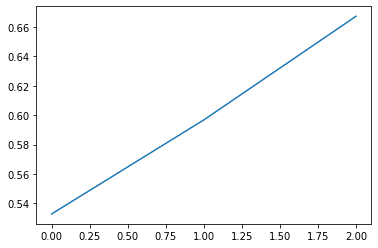

Epoch: [4]  [  0/549]  eta: 0:04:55  lr: 0.000010  loss: 0.4257 (0.4257)  loss_classifier: 0.4002 (0.4002)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0255 (0.0255)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5384  data: 0.3366  max mem: 2772
Epoch: [4]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3781 (0.4313)  loss_classifier: 0.3239 (0.3671)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0566 (0.0642)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1403  data: 0.0067  max mem: 2772
Epoch: [4]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4771 (0.4228)  loss_classifier: 0.4035 (0.3614)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0564 (0.0614)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1415  data: 0.0072  max mem: 2772
Epoch: [4]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5072 (0.4557)  loss_classifier: 0.4392 (0.3904)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0595 (0.0653)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1398  data: 0.0061  max mem: 2772


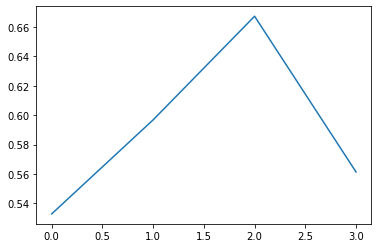

Epoch: [5]  [  0/549]  eta: 0:06:07  lr: 0.000010  loss: 0.4240 (0.4240)  loss_classifier: 0.3679 (0.3679)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0561 (0.0561)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6686  data: 0.5044  max mem: 2772
Epoch: [5]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3737 (0.4308)  loss_classifier: 0.3201 (0.3698)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0443 (0.0610)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1398  data: 0.0063  max mem: 2772
Epoch: [5]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4840 (0.4219)  loss_classifier: 0.4112 (0.3630)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0676 (0.0588)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1404  data: 0.0067  max mem: 2772
Epoch: [5]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5259 (0.4543)  loss_classifier: 0.4430 (0.3918)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0741 (0.0626)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1395  data: 0.0062  max mem: 2772


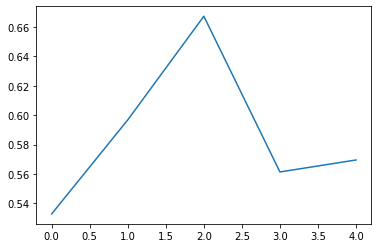

Epoch: [6]  [  0/549]  eta: 0:05:42  lr: 0.000010  loss: 0.5074 (0.5074)  loss_classifier: 0.4142 (0.4142)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0932 (0.0932)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6239  data: 0.4206  max mem: 2772
Epoch: [6]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3794 (0.4310)  loss_classifier: 0.3319 (0.3700)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0364 (0.0610)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1416  data: 0.0072  max mem: 2772
Epoch: [6]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4596 (0.4242)  loss_classifier: 0.4191 (0.3621)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0391 (0.0620)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1403  data: 0.0052  max mem: 2772
Epoch: [6]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5317 (0.4569)  loss_classifier: 0.4358 (0.3912)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0753 (0.0657)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1398  data: 0.0064  max mem: 2772


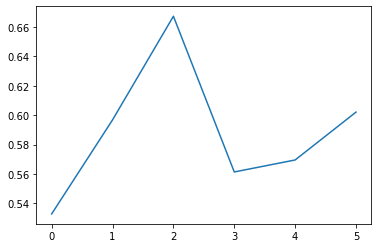

Epoch: [7]  [  0/549]  eta: 0:05:30  lr: 0.000010  loss: 0.4732 (0.4732)  loss_classifier: 0.4112 (0.4112)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0620 (0.0620)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6024  data: 0.3677  max mem: 2772
Epoch: [7]  [200/549]  eta: 0:00:50  lr: 0.000010  loss: 0.3756 (0.4312)  loss_classifier: 0.3311 (0.3700)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0528 (0.0611)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1407  data: 0.0071  max mem: 2772
Epoch: [7]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4922 (0.4234)  loss_classifier: 0.4383 (0.3624)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0631 (0.0610)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1411  data: 0.0070  max mem: 2772
Epoch: [7]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5465 (0.4586)  loss_classifier: 0.4436 (0.3929)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0794 (0.0657)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1402  data: 0.0067  max mem: 2772


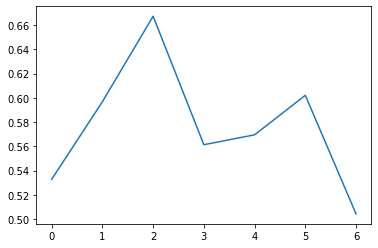

Epoch: [8]  [  0/549]  eta: 0:05:54  lr: 0.000010  loss: 0.4522 (0.4522)  loss_classifier: 0.3540 (0.3540)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0982 (0.0982)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6449  data: 0.4634  max mem: 2772
Epoch: [8]  [200/549]  eta: 0:00:50  lr: 0.000010  loss: 0.3915 (0.4296)  loss_classifier: 0.3266 (0.3679)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0516 (0.0617)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1410  data: 0.0072  max mem: 2772
Epoch: [8]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4644 (0.4213)  loss_classifier: 0.4042 (0.3601)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0620 (0.0612)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1411  data: 0.0072  max mem: 2772
Epoch: [8]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5151 (0.4557)  loss_classifier: 0.4416 (0.3896)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0642 (0.0661)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1394  data: 0.0061  max mem: 2772


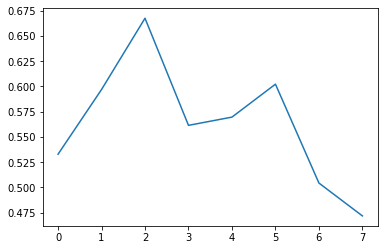

Epoch: [9]  [  0/549]  eta: 0:05:35  lr: 0.000010  loss: 0.4809 (0.4809)  loss_classifier: 0.4148 (0.4148)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0660 (0.0660)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6120  data: 0.4285  max mem: 2772
Epoch: [9]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.4115 (0.4358)  loss_classifier: 0.3334 (0.3714)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0510 (0.0644)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1400  data: 0.0064  max mem: 2772
Epoch: [9]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4635 (0.4249)  loss_classifier: 0.3992 (0.3620)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0595 (0.0628)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1417  data: 0.0076  max mem: 2772
Epoch: [9]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5246 (0.4593)  loss_classifier: 0.4415 (0.3912)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0867 (0.0681)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1401  data: 0.0063  max mem: 2772


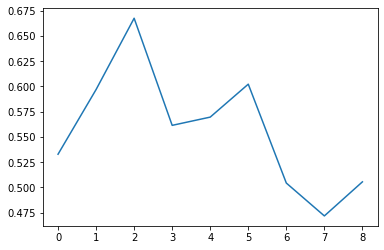

Epoch: [10]  [  0/549]  eta: 0:06:11  lr: 0.000010  loss: 0.4242 (0.4242)  loss_classifier: 0.3506 (0.3506)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0736 (0.0736)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6768  data: 0.5136  max mem: 2772
Epoch: [10]  [200/549]  eta: 0:00:50  lr: 0.000010  loss: 0.3766 (0.4271)  loss_classifier: 0.3364 (0.3653)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0301 (0.0618)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1409  data: 0.0067  max mem: 2772
Epoch: [10]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4939 (0.4208)  loss_classifier: 0.4191 (0.3593)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0756 (0.0616)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1400  data: 0.0055  max mem: 2772
Epoch: [10]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5103 (0.4552)  loss_classifier: 0.4312 (0.3901)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0642 (0.0651)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1395  data: 0.0059  max mem: 2

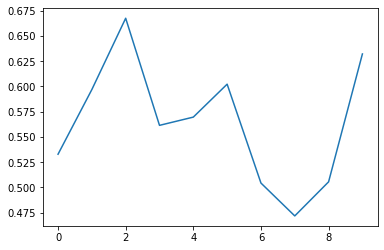

Epoch: [11]  [  0/549]  eta: 0:05:51  lr: 0.000010  loss: 0.4463 (0.4463)  loss_classifier: 0.3851 (0.3851)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0612 (0.0612)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6397  data: 0.4647  max mem: 2772
Epoch: [11]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3718 (0.4309)  loss_classifier: 0.3347 (0.3676)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0533 (0.0633)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1406  data: 0.0073  max mem: 2772
Epoch: [11]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4923 (0.4219)  loss_classifier: 0.4137 (0.3600)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0572 (0.0619)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1410  data: 0.0074  max mem: 2772
Epoch: [11]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5127 (0.4542)  loss_classifier: 0.4484 (0.3895)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0684 (0.0647)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1391  data: 0.0060  max mem: 2

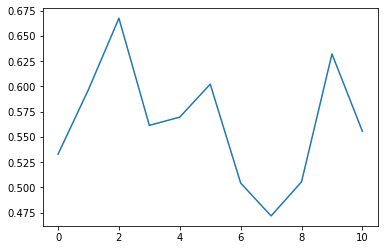

Epoch: [12]  [  0/549]  eta: 0:04:56  lr: 0.000010  loss: 0.3613 (0.3613)  loss_classifier: 0.3473 (0.3473)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0141 (0.0141)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5397  data: 0.3487  max mem: 2772
Epoch: [12]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3850 (0.4267)  loss_classifier: 0.3305 (0.3657)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0545 (0.0609)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1407  data: 0.0071  max mem: 2772
Epoch: [12]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4781 (0.4186)  loss_classifier: 0.4076 (0.3574)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0735 (0.0612)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1417  data: 0.0074  max mem: 2772
Epoch: [12]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5028 (0.4536)  loss_classifier: 0.4368 (0.3878)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0678 (0.0658)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1392  data: 0.0057  max mem: 2

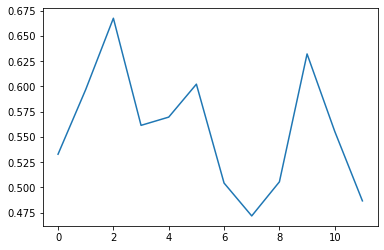

Epoch: [13]  [  0/549]  eta: 0:05:30  lr: 0.000010  loss: 0.4325 (0.4325)  loss_classifier: 0.3958 (0.3958)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0366 (0.0366)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6026  data: 0.4058  max mem: 2772
Epoch: [13]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3777 (0.4309)  loss_classifier: 0.3297 (0.3711)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0373 (0.0598)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1407  data: 0.0069  max mem: 2772
Epoch: [13]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4876 (0.4190)  loss_classifier: 0.4262 (0.3599)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0479 (0.0591)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1409  data: 0.0071  max mem: 2772
Epoch: [13]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5231 (0.4543)  loss_classifier: 0.4486 (0.3896)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0618 (0.0647)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1394  data: 0.0060  max mem: 2

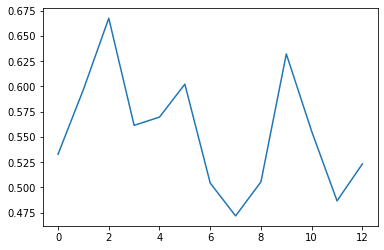

Epoch: [14]  [  0/549]  eta: 0:05:55  lr: 0.000010  loss: 0.4340 (0.4340)  loss_classifier: 0.3499 (0.3499)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0840 (0.0840)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6468  data: 0.4737  max mem: 2772
Epoch: [14]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3670 (0.4306)  loss_classifier: 0.3189 (0.3687)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0463 (0.0619)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1406  data: 0.0074  max mem: 2772
Epoch: [14]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4933 (0.4238)  loss_classifier: 0.4102 (0.3614)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0701 (0.0624)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1402  data: 0.0052  max mem: 2772
Epoch: [14]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5126 (0.4564)  loss_classifier: 0.4459 (0.3907)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0700 (0.0657)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1396  data: 0.0065  max mem: 2

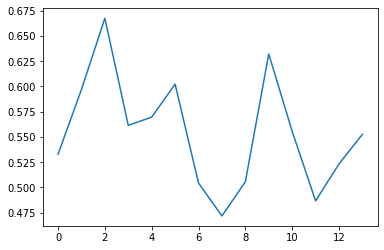

Epoch: [15]  [  0/549]  eta: 0:05:31  lr: 0.000010  loss: 0.4590 (0.4590)  loss_classifier: 0.4278 (0.4278)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0312 (0.0312)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6031  data: 0.4064  max mem: 2772
Epoch: [15]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3664 (0.4343)  loss_classifier: 0.3189 (0.3703)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0533 (0.0641)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1413  data: 0.0073  max mem: 2772
Epoch: [15]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4868 (0.4275)  loss_classifier: 0.4248 (0.3641)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0610 (0.0634)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1407  data: 0.0070  max mem: 2772
Epoch: [15]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5267 (0.4589)  loss_classifier: 0.4450 (0.3928)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0768 (0.0661)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1393  data: 0.0063  max mem: 2

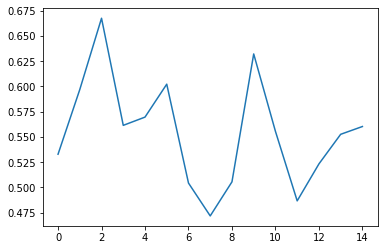

Epoch: [16]  [  0/549]  eta: 0:06:14  lr: 0.000010  loss: 0.4093 (0.4093)  loss_classifier: 0.3824 (0.3824)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0269 (0.0269)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6813  data: 0.5285  max mem: 2772
Epoch: [16]  [200/549]  eta: 0:00:50  lr: 0.000010  loss: 0.3667 (0.4302)  loss_classifier: 0.3226 (0.3688)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0348 (0.0614)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1413  data: 0.0077  max mem: 2772
Epoch: [16]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4734 (0.4217)  loss_classifier: 0.4239 (0.3614)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0589 (0.0603)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1411  data: 0.0075  max mem: 2772
Epoch: [16]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5218 (0.4563)  loss_classifier: 0.4455 (0.3917)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0778 (0.0646)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1403  data: 0.0069  max mem: 2

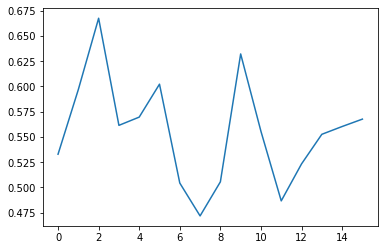

Epoch: [17]  [  0/549]  eta: 0:05:44  lr: 0.000010  loss: 0.4052 (0.4052)  loss_classifier: 0.3919 (0.3919)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0134 (0.0134)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6273  data: 0.4528  max mem: 2772
Epoch: [17]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3701 (0.4331)  loss_classifier: 0.3216 (0.3715)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0446 (0.0616)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1405  data: 0.0067  max mem: 2772
Epoch: [17]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4822 (0.4272)  loss_classifier: 0.4280 (0.3659)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0542 (0.0614)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1411  data: 0.0069  max mem: 2772
Epoch: [17]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5099 (0.4567)  loss_classifier: 0.4356 (0.3922)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0669 (0.0645)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1389  data: 0.0059  max mem: 2

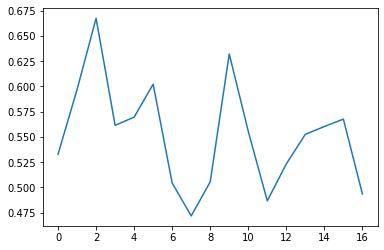

Epoch: [18]  [  0/549]  eta: 0:04:49  lr: 0.000010  loss: 0.4989 (0.4989)  loss_classifier: 0.4104 (0.4104)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0885 (0.0885)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5264  data: 0.3224  max mem: 2772
Epoch: [18]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3720 (0.4262)  loss_classifier: 0.3238 (0.3641)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0496 (0.0622)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1410  data: 0.0073  max mem: 2772
Epoch: [18]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4870 (0.4208)  loss_classifier: 0.4246 (0.3594)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0748 (0.0615)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1396  data: 0.0051  max mem: 2772
Epoch: [18]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5087 (0.4556)  loss_classifier: 0.4422 (0.3896)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0708 (0.0660)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1398  data: 0.0062  max mem: 2

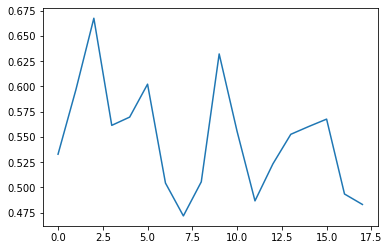

Epoch: [19]  [  0/549]  eta: 0:04:40  lr: 0.000010  loss: 0.4503 (0.4503)  loss_classifier: 0.3999 (0.3999)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0503 (0.0503)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5103  data: 0.3020  max mem: 2772
Epoch: [19]  [200/549]  eta: 0:00:50  lr: 0.000010  loss: 0.3815 (0.4347)  loss_classifier: 0.3356 (0.3725)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0464 (0.0622)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1413  data: 0.0071  max mem: 2772
Epoch: [19]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4845 (0.4254)  loss_classifier: 0.4260 (0.3634)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0664 (0.0620)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1413  data: 0.0076  max mem: 2772
Epoch: [19]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5193 (0.4575)  loss_classifier: 0.4451 (0.3926)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0749 (0.0649)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1391  data: 0.0063  max mem: 2

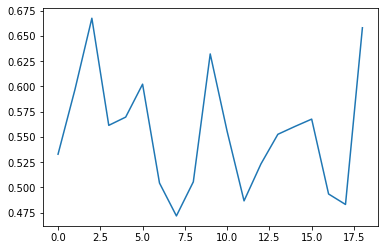

Epoch: [20]  [  0/549]  eta: 0:04:43  lr: 0.000010  loss: 0.4939 (0.4939)  loss_classifier: 0.3883 (0.3883)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.1056 (0.1056)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5170  data: 0.3304  max mem: 2772
Epoch: [20]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3695 (0.4352)  loss_classifier: 0.3267 (0.3693)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0492 (0.0659)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1399  data: 0.0068  max mem: 2772
Epoch: [20]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4776 (0.4254)  loss_classifier: 0.4281 (0.3615)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0448 (0.0639)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1408  data: 0.0073  max mem: 2772
Epoch: [20]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5325 (0.4584)  loss_classifier: 0.4474 (0.3912)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0804 (0.0672)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1393  data: 0.0062  max mem: 2

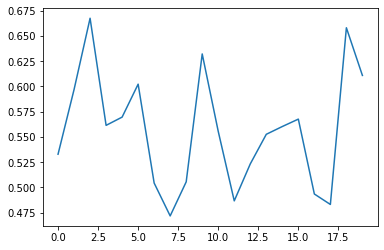

Epoch: [21]  [  0/549]  eta: 0:05:00  lr: 0.000010  loss: 0.4288 (0.4288)  loss_classifier: 0.3668 (0.3668)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0619 (0.0619)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5482  data: 0.3699  max mem: 2772
Epoch: [21]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3761 (0.4286)  loss_classifier: 0.3295 (0.3687)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0359 (0.0599)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1402  data: 0.0069  max mem: 2772
Epoch: [21]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4982 (0.4239)  loss_classifier: 0.4092 (0.3633)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0686 (0.0606)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1402  data: 0.0068  max mem: 2772
Epoch: [21]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5273 (0.4571)  loss_classifier: 0.4473 (0.3917)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0705 (0.0654)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1396  data: 0.0058  max mem: 2

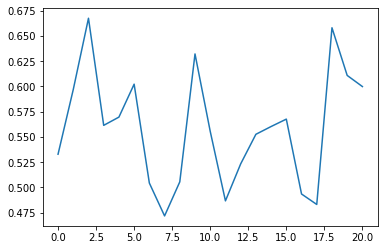

Epoch: [22]  [  0/549]  eta: 0:06:26  lr: 0.000010  loss: 0.4119 (0.4119)  loss_classifier: 0.3594 (0.3594)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0526 (0.0526)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.7032  data: 0.5265  max mem: 2772
Epoch: [22]  [200/549]  eta: 0:00:50  lr: 0.000010  loss: 0.3772 (0.4322)  loss_classifier: 0.3279 (0.3681)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0455 (0.0641)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1409  data: 0.0074  max mem: 2772
Epoch: [22]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.5069 (0.4244)  loss_classifier: 0.4360 (0.3606)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0549 (0.0638)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1402  data: 0.0054  max mem: 2772
Epoch: [22]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5339 (0.4580)  loss_classifier: 0.4541 (0.3904)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0640 (0.0676)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1391  data: 0.0059  max mem: 2

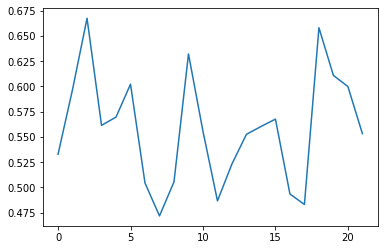

Epoch: [23]  [  0/549]  eta: 0:05:50  lr: 0.000010  loss: 0.5522 (0.5522)  loss_classifier: 0.4259 (0.4259)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.1263 (0.1263)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6379  data: 0.4351  max mem: 2772
Epoch: [23]  [200/549]  eta: 0:00:49  lr: 0.000010  loss: 0.3600 (0.4359)  loss_classifier: 0.3331 (0.3717)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0293 (0.0643)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1410  data: 0.0071  max mem: 2772
Epoch: [23]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4724 (0.4242)  loss_classifier: 0.4093 (0.3612)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0694 (0.0630)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1412  data: 0.0081  max mem: 2772
Epoch: [23]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5295 (0.4577)  loss_classifier: 0.4451 (0.3912)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0754 (0.0665)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1401  data: 0.0068  max mem: 2

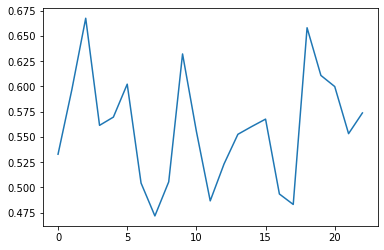

Epoch: [24]  [  0/549]  eta: 0:06:06  lr: 0.000010  loss: 0.4455 (0.4455)  loss_classifier: 0.3762 (0.3762)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0693 (0.0693)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6683  data: 0.5113  max mem: 2772
Epoch: [24]  [200/549]  eta: 0:00:50  lr: 0.000010  loss: 0.3646 (0.4278)  loss_classifier: 0.3247 (0.3674)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0434 (0.0604)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1413  data: 0.0068  max mem: 2772
Epoch: [24]  [400/549]  eta: 0:00:21  lr: 0.000010  loss: 0.4674 (0.4208)  loss_classifier: 0.4240 (0.3614)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0486 (0.0594)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1411  data: 0.0079  max mem: 2772
Epoch: [24]  [548/549]  eta: 0:00:00  lr: 0.000010  loss: 0.5244 (0.4547)  loss_classifier: 0.4409 (0.3912)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0850 (0.0635)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.1393  data: 0.0064  max mem: 2

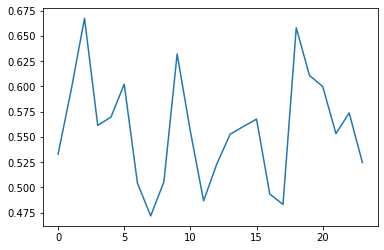

In [ ]:
num_epochs = 24
losses_epochs = []
for epoch in range(1, num_epochs + 1):
    losses,metriclogger = validation_one_epoch(model, optimizer, data_loader_test, device, epoch, print_freq=200)
    losses_epochs.append(losses[-1])
    
    plt.plot(losses_epochs)
    plt.show()
    # update the learning rate
    # lr_scheduler.step()
    # evaluate on the test dataset

QUALITATIVE TESTING

In [ ]:
dataset._img_paths[0]

'train/MOT17-02/img1/000001.jpg'

['MOT17-01']
test/MOT17-01/seqinfo.ini
548


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test/MOT17-01/img1/000001.jpg
<class 'torch.Tensor'>2


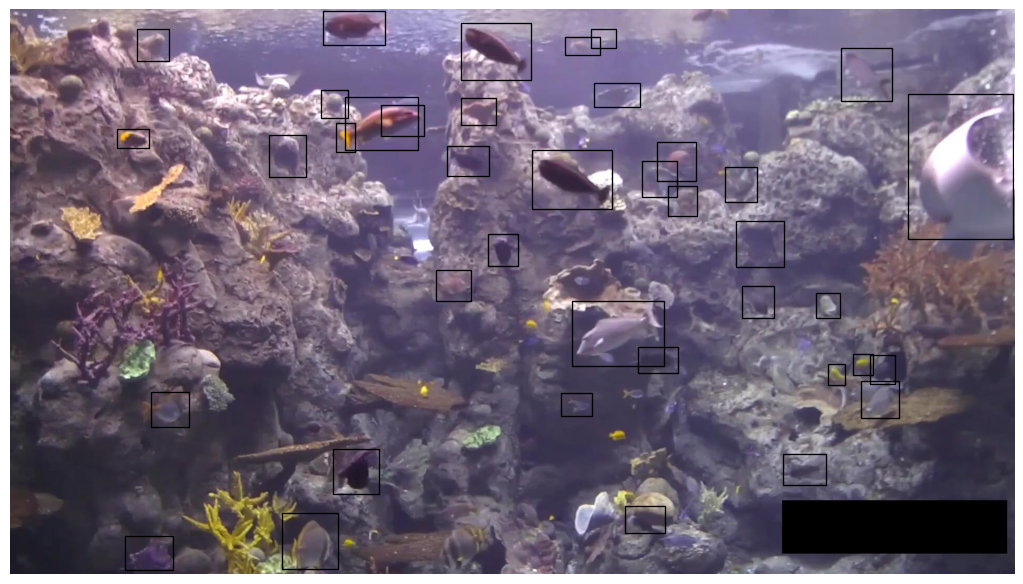

<class 'torch.Tensor'>2


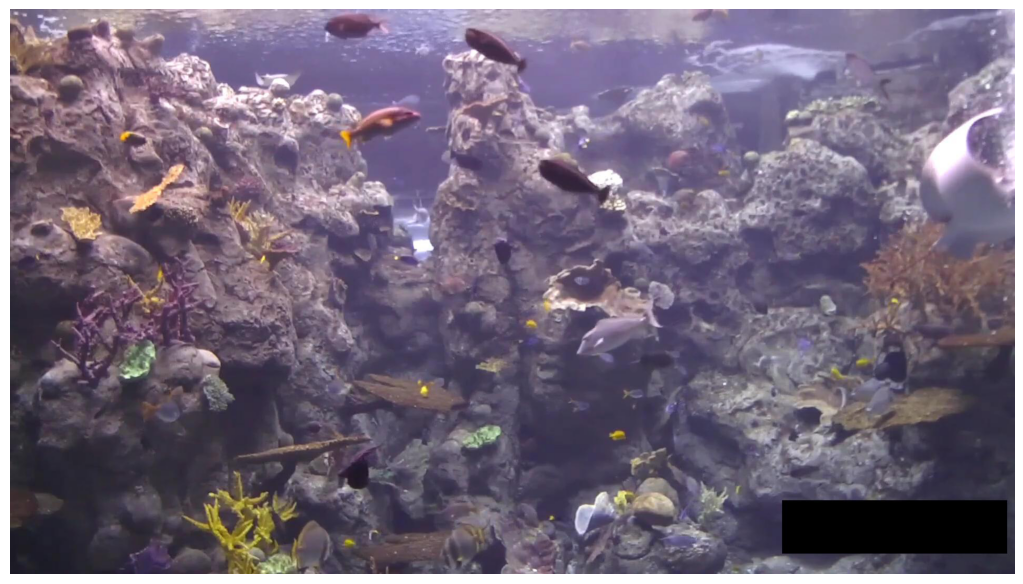

In [ ]:
# pick one image from the test set
dataset = MOT17ObjDetect('test', get_transform(train=False))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

for imgs, target in data_loader:
    print(dataset._img_paths[0])
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([imgs[0].to(device)])[0]
    
    plot(imgs[0], prediction['boxes'])
    plot(imgs[0], target[0]['boxes'])
    break
